   __.. И тогда этот студент _кинулся собакой в доску___
   
   The aim of this project is to study russian verbs of a certain kind. The most popular of these verbs is _броситься_. So what is so special about it? It seems to be rather ambiguous: compare phrases _броситься в ноги_ and _броситься в воду_ or _броситься в воду_ and _броситься бежать_ -- you can easily see that in the first pair verb either is or is not a metaphor and therefore either doesn't mean an actual movement or does. In the second pair while there is movement in both phrases, in case of _броситься бежать_ it is actually the verb _бежать_ that references to the movement while _броситься_ is grammaticalized as an inchoative. My idea is to compare different contexts of this verb (and the others alike) and look for paterns. Other verbs of the same kind are: _кинуться_, _метнуться_, _ринуться_ and _рвануться_.

   First of all we need to establish all types of contexts of our set of verbs. Let's make a database! 

In [1]:
import pandas as pd
import csv
import sqlite3

import re

from tqdm import tqdm

In [2]:
conn = sqlite3.connect('RusCorpora_data.db')
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS examples 
(id int PRIMARY KEY, table_id text, left text, center text, punct text, right text, title text, author text, birthday text, header text, created text, sphere text, type text, publ text, publ_year text, medium text, ambiguity text, full text)
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS verbs 
(id int PRIMARY KEY, verb_name text) 
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS example_to_verb 
(id INTEGER PRIMARY KEY AUTOINCREMENT, id_example int, id_verb int) 
""")

conn.commit()
conn.close()

In [3]:
regex_df_id = re.compile('^[1-5].[0-9]+')

In [4]:
def get_nth_df(df):
    blocks = []
    for i in range(len(df)):
        try:
            block = {}
            block['id'] = df.iloc[i, 17]
            block['left'] = df.iloc[i, 0]
            block['center'] = df.iloc[i, 1]
            block['punct'] = df.iloc[i, 2]
            block['right'] = df.iloc[i, 3]
            block['title'] = df.iloc[i, 4]
            block['author'] = df.iloc[i, 5]
            block['birthday'] = df.iloc[i, 6]
            block['header'] = df.iloc[i, 7]
            block['created'] = df.iloc[i, 8]
            block['sphere'] = df.iloc[i, 9]
            block['type'] = df.iloc[i, 10]
            block['publication'] = df.iloc[i, 12]
            block['publ_year'] = df.iloc[i, 13]
            block['medium'] = df.iloc[i, 14]
            block['ambiguity'] = df.iloc[i, 15]
            block['full'] = df.iloc[i, 16]
            blocks.append(block)
        except Exception as e:
            print('THE 1st level MISTAKE IS HERE', e, end = '\n\n')
    for b in blocks:
        idx = regex_df_id.findall(b['id'])[0]
        if idx not in seen_examples:
            try:
                b['id'] = idx
            except Exception as e:
                print('THE 2nd level MISTAKE IS HERE', e, end = '\n\n')
        #else:
            #print('Seen', b['id'], end = '\n\n')
    return blocks

In [5]:
def write_to_db(block, verb):
    verbs = []
    if verb in db_verbs:
        verbs.append(db_verbs[verb])
    else:
        db_verbs[verb] = len(db_verbs) + 1 
        cur.execute('INSERT INTO verbs VALUES (?, ?)', (len(db_verbs), verb))
        conn.commit()
        verbs.append(db_verbs[verb])    
    example_id = len(seen_examples) + 1
    cur.execute(
        'INSERT INTO examples VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)',
        (example_id, block['id'], block['left'], block['center'], block['punct'], block['right'], block['title'], 
         block['author'], block['birthday'], block['header'], block['created'], block['sphere'], block['type'], 
         block['publication'], block['publ_year'], block['medium'], block['ambiguity'], block['full'])
    )   
    verbs = [(example_id, v) for v in verbs]
    cur.executemany(
        'INSERT INTO example_to_verb (id_example, id_verb) VALUES (?, ?)',
        verbs
    )
    conn.commit()
    seen_examples.add(block['id'])

In [6]:
conn = sqlite3.connect('RusCorpora_data.db')
cur = conn.cursor()
cur.execute('SELECT verb_name, id FROM verbs')

db_verbs = {}
for name, idx in cur.fetchall():
    db_verbs[name] = idx

cur.execute('SELECT table_id FROM examples')
seen_examples = set(i[0] for i in cur.fetchall())

In [7]:
def run_all(names, cyr_names):
    df_list = []
    for i in range(len(names)):
        cyr = cyr_names[i]
        print('Verb:', cyr, end = '\n')
        name = names[i]
        df_list.append(pd.read_csv(name + ".csv", sep='\t', encoding='utf-8'))
        print('There are', len(df_list[i]), 'examples with this verb', end = '\n')
        print('It\'s going to take a while. Wait for it :)', end = '\n\n')
        df_list[i]["df_id"] = ['' for _ in range(len(df_list[i]))]
        for j in range(len(df_list[i])):
            df_list[i].iloc[j, 17] = str(i+1) + '.' + str(j+1)
        blocks = get_nth_df(df_list[i])
        for block in tqdm(blocks):
            write_to_db(block, cyr)

In [8]:
run_all(["brositsya", "kinutsya", "metnutsya", "rinutsya", "rvanutsya"], ["броситься", "кинуться", "метнуться", "ринуться", "рвануться"])

Verb: броситься
There are 34729 examples with this verb
It's going to take a while. Wait for it :)



100%|█████████████████████████████████████| 34729/34729 [06:59<00:00, 82.79it/s]


Verb: кинуться
There are 11127 examples with this verb
It's going to take a while. Wait for it :)



100%|█████████████████████████████████████| 11127/11127 [02:12<00:00, 83.67it/s]


Verb: метнуться
There are 2387 examples with this verb
It's going to take a while. Wait for it :)



100%|███████████████████████████████████████| 2387/2387 [00:28<00:00, 83.29it/s]


Verb: ринуться
There are 3835 examples with this verb
It's going to take a while. Wait for it :)



100%|███████████████████████████████████████| 3835/3835 [00:46<00:00, 83.29it/s]


Verb: рвануться
There are 3076 examples with this verb
It's going to take a while. Wait for it :)



100%|███████████████████████████████████████| 3076/3076 [00:37<00:00, 82.04it/s]


As we can see every example is accounted for.

In [9]:
cur.execute("""
SELECT count(example_to_verb.id) as cnt, verbs.verb_name 
    FROM example_to_verb 
        JOIN verbs ON verbs.id = example_to_verb.id_verb
            GROUP BY example_to_verb.id_verb
            ORDER BY cnt DESC;
""")
cur.fetchall()

[(34729, 'броситься'),
 (11127, 'кинуться'),
 (3835, 'ринуться'),
 (3076, 'рвануться'),
 (2387, 'метнуться')]

Now that we have a database let's make a dataframe out of it as it is easier to work with:

In [134]:
import pandas as pd

sql_query = pd.read_sql_query ('''
                               SELECT
                               verb_name, left, center, punct, right, title, author, birthday, header, created, sphere, type, publ, publ_year, medium, ambiguity, full
                               FROM example_to_verb
                                   JOIN verbs ON example_to_verb.id_verb=verbs.id
                                   JOIN examples ON example_to_verb.id_example=examples.id
                               ''', conn)

df = pd.DataFrame(sql_query)

df.head(3)

,verb_name,left,center,punct,right,title,author,birthday,header,created,sphere,type,publ,publ_year,medium,ambiguity,full
0,броситься,так мужественно шпагами назад на неприятеля,бросились,",",которого удивително (понеже уже наш вал,А. М. Макаров (ред.). Гистория Свейской войны ...,А. М. Макаров (ред.),1674,Гистория Свейской войны (Поденная записка Петр...,1698-1721,официально-деловая | публицистика,"дневник, записные книжки",Гистория Свейской войны (Поденная записка Петр...,2004,книга,омонимия не снята,"И уже сей пост был отчаян, но как одна рота пе..."
1,броситься,"побивъ прежде 20 человѣкъ Черкасъ, которые",бросились,,грабить убитыхъ Татаръ.,I. К. Таубертъ. Краткое описаніе всѣхъ случаев...,I. К. Таубертъ,1717,Краткое описаніе всѣхъ случаевъ касающихся до ...,1738,учебно-научная,монография,Краткое описаніе всѣхъ случаевъ касающихся до ...,1738,книга,омонимия не снята,"Но какъ имъ въ томъ не удалось, то они опять н..."
2,броситься,внешний воздух отвернутым гвоздем в него,бросится,.,None,М. В. Ломоносов. Волфианская экспериментальная...,М. В. Ломоносов,1711,"Волфианская экспериментальная физика, с немецк...",1745,учебно-научная,учебник | перевод,М. В. Ломоносов. Полное собрание сочинений: В ...,1950,книга,омонимия не снята,"То же воспоследует, ежели в стеклянном колокол..."


In [135]:
verbs = []
for i in range(len(df)):
    if df.iloc[i, 0] not in verbs:
        verbs.append(df.iloc[i, 0])
        
contain_punct = df[df['punct'] != ' ']
print('There are', len(contain_punct), 'examples with puctuation after the verbs')
for i in verbs:
    print(i)
print('\n', round(len(contain_punct)/len(df['punct']), 2), 'of all examples')
contain_punct.head(3)

There are 3177 examples with puctuation after the verbs
броситься
кинуться
метнуться
ринуться
рвануться

 0.06 of all examples


,verb_name,left,center,punct,right,title,author,birthday,header,created,sphere,type,publ,publ_year,medium,ambiguity,full
0,броситься,так мужественно шпагами назад на неприятеля,бросились,",",которого удивително (понеже уже наш вал,А. М. Макаров (ред.). Гистория Свейской войны ...,А. М. Макаров (ред.),1674,Гистория Свейской войны (Поденная записка Петр...,1698-1721,официально-деловая | публицистика,"дневник, записные книжки",Гистория Свейской войны (Поденная записка Петр...,2004,книга,омонимия не снята,"И уже сей пост был отчаян, но как одна рота пе..."
2,броситься,внешний воздух отвернутым гвоздем в него,бросится,.,None,М. В. Ломоносов. Волфианская экспериментальная...,М. В. Ломоносов,1711,"Волфианская экспериментальная физика, с немецк...",1745,учебно-научная,учебник | перевод,М. В. Ломоносов. Полное собрание сочинений: В ...,1950,книга,омонимия не снята,"То же воспоследует, ежели в стеклянном колокол..."
4,броситься,"Все лучше, нежели в воду",броситься,.,None,А. П. Сумароков. Чудовищи (1750),А. П. Сумароков,1717,Чудовищи,1750,художественная,комедия | пьеса,А. П. Сумароков. Драматические произведения,1990,электронный текст,омонимия не снята,"Все лучше, нежели в воду броситься."


In [20]:
import spacy.cli
nlp = spacy.cli.download("ru_core_news_sm")
nlp = spacy.load("ru_core_news_sm")

from spacy import displacy
from spacy import tokenizer

2022-12-14 22:32:41.543452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 22:32:41.670273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 22:32:41.670298: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 22:32:42.478655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 4.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Usually punctation mark is udes to mark a border of the clause -- therefore, it is within reason to remove all examples where _броситься_ (or other verbs) is the last word in the clause. Nevertheless there are few arguments against this:
1) Some punctuation marks -- a hyphen, for instance, -- don't mark an end of a clause (_А __кинусь-ка__ я сам туда -- и все дела!_)
2) Even if there are dots, commas, etc. in df['punct'] the verbs in question have a dependant group in the left part of the context

..but there are only a few examples of this kind and it's considerably more difficult to deal with it.

In [154]:
df1 = df[df['punct'] == ' ']
seen_pos1 = {}
seen_pos2 = {}    

for i in range(len(df1)):
    try:
        abstr = nlp(df1.iloc[i, 4])
        if abstr[0].pos_ not in seen_pos1:
            if abstr[0].pos_ + ' + ' + abstr[1].pos_ not in seen_pos2:
                seen_pos1[abstr[0].pos_] = 1
                seen_pos2[abstr[0].pos_ + ' + ' + abstr[1].pos_] = 1
                #print('new', abstr[0].pos_ + ' + ' + abstr[1].pos_)
            else:
                seen_pos1[abstr[0].pos_] = 1
                seen_pos2[abstr[0].pos_ + ' + ' + abstr[1].pos_] += 1
                print('That\'s unusual!', abstr[0].pos_ + ' + ' + abstr[1].pos_)
        else:
            if abstr[0].pos_ + ' + ' + abstr[1].pos_ not in seen_pos2:
                seen_pos1[abstr[0].pos_] += 1
                seen_pos2[abstr[0].pos_ + ' + ' + abstr[1].pos_] = 1
                #print('old but gold', abstr[0].pos_ + ' + ' + abstr[1].pos_)
            else:
                seen_pos1[abstr[0].pos_] += 1
                seen_pos2[abstr[0].pos_ + ' + ' + abstr[1].pos_] += 1
                #print('old', abstr[0].pos_ + ' + ' + abstr[1].pos_)
    except Exception as e:
        print(e)

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'NoneType'>


Here we have all types of constructions that follow sought-for verb (only the ones that were found in at least 1% of all examples):

In [155]:
pairs = {}

for k in sorted(seen_pos2, key=seen_pos2.get, reverse=True):
    if seen_pos2[k] > len(df1)/100 and 'PUNCT' not in k:
        print(k, '\t', seen_pos2[k])
        pairs[k] = seen_pos2[k]

ADP + NOUN 	 18973
ADP + PRON 	 5579
ADP + ADJ 	 3073
ADP + PROPN 	 2106
PRON + ADP 	 1704
ADP + DET 	 1567
ADV + ADP 	 1465
VERB + NOUN 	 1382
VERB + ADP 	 786
NOUN + ADP 	 774
NOUN + NOUN 	 587
PRON + VERB 	 558
VERB + PRON 	 534
AUX + ADP 	 522


Some of these constructions could be combined. For example, it doesn't change a lot whether an adposition is followed by a noun or a pronoun or an adjective (_кинуться к дому_ or _кинуться к нему_ or _кинуться к старому [другу]_). A _verb + verb_ construction doesn't seem to change a lot with different follow-up words (_броситься бежать_, _кинуться помогать_ are ~independant constructions on their own):

In [156]:
pairs_new = {}
i = 0
j = 0

for k in pairs:
    if 'ADP +' in k:
        i += pairs[k]        
    if 'VERB +' in k:
        j += pairs[k]        

for k in pairs:
    if 'ADP +' not in k and 'VERB +' not in k:
        pairs_new[k] = pairs[k]
    elif 'ADP +' in k:
        pairs_new['ADP +\t'] = i
    elif 'VERB +' in k:
        pairs_new['VERB +\t'] = j

for k in sorted(pairs_new, key=pairs_new.get, reverse=True):
    print(k, '\t', pairs_new[k])

ADP +	 	 31298
VERB +	 	 2702
PRON + ADP 	 1704
ADV + ADP 	 1465
NOUN + ADP 	 774
NOUN + NOUN 	 587
PRON + VERB 	 558
AUX + ADP 	 522


   Now let's take a look at constructions of a type _броситься/кинуться/.. + предлог + существительное_ as it is the most frequent. I am going to use lists of 3-grams from RusCorpora. It is important to mention that I'm going to look as for the construtions with dependant group after the verb as for the ones with dependant group before the verb (_краска бросилась ему __в лицо___ and _ему __в лицо__ бросилась краска_) -- but at the same time I'm only going to pay attention to the dependant groups right next to the verb (_краска бросилась __ему__ в лицо_ and _ему __в лицо__ бросилась краска_).
   
   We need to use a model (from https://rusvectores.org/ru/):

In [13]:
#!pip install wget
import wget

#!pip install gensim -U
import sys
import gensim, logging

import zipfile

In [14]:
model_url = 'http://vectors.nlpl.eu/repository/20/220.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

100% [..................................................] 638171816 / 638171816

In [17]:
names = ["brositsya", "kinutsya", "metnutsya", "rinutsya", "rvanutsya"]
#verbs = ["броситься", "кинуться", "метнуться", "ринуться", "рвануться"]
df_list = []

for i in range(5):
    name = names[i]
    df_list.append(pd.read_csv(name + "+s.csv", sep='\t', encoding='utf-8'))

In [18]:
from pymystem3 import Mystem
import pymorphy2

m = Mystem()

In [19]:
for i in range(len(df_list)):
    for j in range(len(df_list[i])):
        lemmas = m.lemmatize(df_list[i].iloc[j, 3])
        df_list[i].iloc[j, 3] = ''.join(lemmas[:-1])
    verb = verbs[i]
    for j in range(len(df_list[i])):
        if ' ' + verb in df_list[i].iloc[j, 3]:
            df_list[i].iloc[j, 3] = verb + ' ' + df_list[i].iloc[j, 3][:-(len(verb)+1)]
        elif 'бросаться ' in df_list[i].iloc[j, 3]:
            df_list[i].iloc[j, 3] = 'броситься' + df_list[i].iloc[j, 3][len('бросаться'):]
        elif ' бросаться' in df_list[i].iloc[j, 3]:
            df_list[i].iloc[j, 3] = 'броситься ' + df_list[i].iloc[j, 3][:-(len('бросаться')+1)]
    df_list[i]['Вхождения'] = df_list[i][['Вхождения', 'Фрагмент']].groupby(['Фрагмент'])['Вхождения'].transform('sum')
    df_list[i] = df_list[i][['Вхождения', 'Фрагмент']].drop_duplicates()
    df_list[i] = df_list[i].sort_values(['Вхождения'], ascending = [False])
    df_list[i] = df_list[i][df_list[i]['Вхождения'] > 19]

df_all = pd.concat(df_list)
df_all

,Вхождения,Фрагмент
0,1042,броситься в глаз
37,392,броситься в вода
96,346,броситься к дверь
43,242,броситься на шея
100,215,броситься к окно
...,...,...
104,35,ринуться в атака
109,24,ринуться к выход
2,77,рвануться с место
23,68,рвануться в сторона


Now that we have a list of 3-grams let's clusterize it. We will start with constructions with the verb _броситься_ (as it is the only one with a significant number of examples):

In [21]:
#!pip install scipy
import scipy
import scipy.cluster.hierarchy as hcluster
#!pip install -U scikit-learn
from sklearn.cluster import KMeans

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [177]:
array_list1 = []
for j in range(len(df_list[0])):
    v = []
    abstr = nlp(df_list[0].iloc[j, 1])
    for token in abstr:
        if token.pos_ != 'ADP':
            n = ''
            n = n + token.text + '_' + token.pos_
            if n in model:
                vector = []
                for item in model[n]:
                    vector.append(float(item))
                v.append(np.array(vector))
            else:
                print('Слова "%s" нет в модели!' % n)
    if len(v) == 2:
        v1 = [v[0], v[1]]
        v1 = np.sum(v1, axis=0)
        array_list1.append(v1)
            
X1 = np.array(array_list1)
print(X1)
print (X1.shape)

[[-2.5803079   1.11180633  3.75898916 ... -0.22919584 -0.32119608
  -1.69358012]
 [ 0.71967363  3.4517166   1.37715328 ...  1.01699364  0.28019309
  -1.73047659]
 [-3.88425612  3.62893194  1.9522934  ... -3.11500251 -1.62291205
  -4.84862933]
 ...
 [-5.00197959 -3.48804766  3.42454237 ... -0.77923724  4.72199929
  -0.70034811]
 [-2.21961944  5.85423273 -1.343328   ... -0.99042094  1.09995472
  -0.0487349 ]
 [-4.06276739  4.52528471 -1.84849072 ... -1.58486176 -0.05602849
  -2.66654786]]
(52, 300)


For some reason adpositions are absent from the model. Should it be an issue? I assumed that it's ok to just remove adpositions altogether since they don't contribute a lot into the meaning (at least we can still understand the meaning of the construction without adposition).

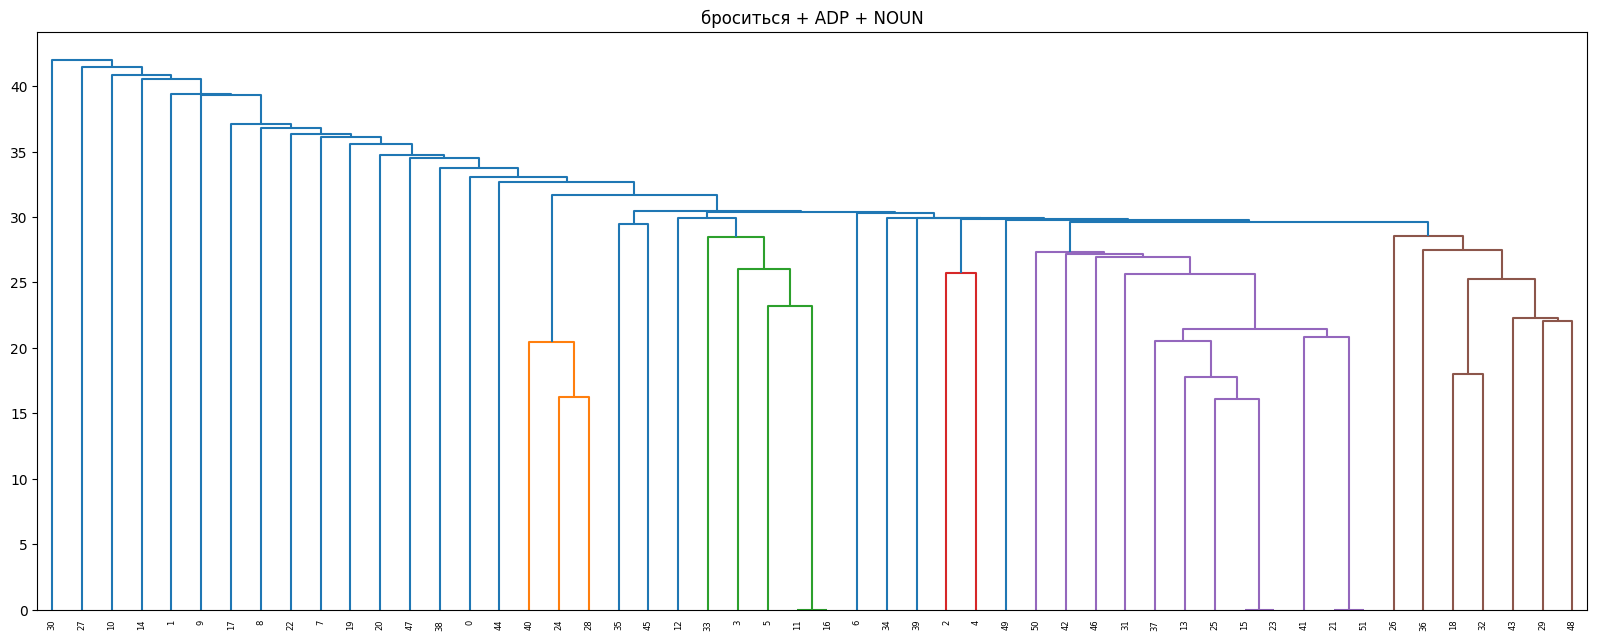

In [178]:
Z1 = hcluster.linkage(X1)
plt.figure()
dn = hcluster.dendrogram(Z1)
plt.title("броситься + ADP + NOUN")
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

There is a file (brositsya+s.png) in the folder in case if the plot is unreadable.

Let's compare clusters to the list of the constructions:

In [161]:
for j in range(len(df_list[0])):
    print(j, ' – ', df_list[0].iloc[j, 1])

0  –  броситься в глаз
1  –  броситься в вода
2  –  броситься к дверь
3  –  броситься на шея
4  –  броситься к окно
5  –  броситься на колено
6  –  броситься в объятие
7  –  броситься в сторона
8  –  броситься к выход
9  –  броситься на помощь
10  –  броситься в атака
11  –  броситься к нога
12  –  броситься в голова
13  –  броситься на диван
14  –  броситься в море
15  –  броситься на постель
16  –  броситься в нога
17  –  броситься в река
18  –  броситься с крик
19  –  броситься на земля
20  –  броситься к телефон
21  –  броситься в комната
22  –  броситься в лицо
23  –  броситься в постель
24  –  броситься к отец
25  –  броситься на кровать
26  –  броситься в погоня
27  –  броситься на улица
28  –  броситься к мать
29  –  броситься в ужас
30  –  броситься под поезд
31  –  броситься к стол
32  –  броситься с визг
33  –  броситься в рука
34  –  броситься со слеза
35  –  броситься в куст
36  –  броситься в паника
37  –  броситься в кресло
38  –  броситься в дом
39  –  броситься на пол


1. Orange cluster (40, 24, 28): _броситься к муж_, _броситься к отец_ and _броситься к мать_;
2. Green cluster (33, 3, 5, 11, 16): _броситься в рука_, _броситься на шея_, _броситься на колено_, _броситься к нога_ and _броситься в нога_;
3. Red cluster (2, 4): _броситься к дверь_ and _броситься к окно_;
4. Purple cluster (50, 42, 46, 31, 37, 13, 25, 15, 23, 41, 21, 51): _броситься в кабинет_, _броситься в коридор_, _броситься в кухня_, _броситься к стол_, _броситься в кресло_, _броситься на диван_, _броситься на кровать_, _броситься на постель_, _броситься в постель_, _броситься в спальня_, _броситься в комната_ and _броситься из комната_;
5. Brown cluster (26, 36, 18, 32, 43, 29, 48): ___броситься в погоня___, _броситься в паника_, _броситься с крик_, _броситься с визг_, _броситься в отчаяние_, _броситься в ужас_ and _броситься в испуг_

We can clearly see the similarity within each cluster but the 5-th one is remarcable: while all other constructions are represented with actants, these are all adjunct with the exception of _броситься в погоню_. And even though it seems to be purely coincidental there's still some semantic similarity between _броситься в погоню_ and _броситься с криками_. It is also worth mentioning that the first construction to be separated from the rest is (30) _броситься под поезд_ -- because we didn't consider adpositions while building vectors. And while the direction of the movement (that makes this construction as specific as it is) is marked solely by an adposition _под_, the model imediatly separated it.

Let's take a look at the verb _кинуться_:

In [205]:
array_list2 = []
for j in range(len(df_list[1])):
    v = []
    abstr = nlp(df_list[1].iloc[j, 1])
    for token in abstr:
        if token.pos_ != 'ADP':
            n = ''
            n = n + token.text + '_' + token.pos_
            if n in model:
                vector = []
                for item in model[n]:
                    vector.append(float(item))
                v.append(np.array(vector))
            else:
                print('Слова "%s" нет в модели!' % n)
    if len(v) == 2:
        v1 = [v[0], v[1]]
        v1 = np.sum(v1, axis=0)
        array_list2.append(v1)
            
X2 = np.array(array_list2)
print(X2)
print (X2.shape)

[[-1.9573645   3.02196527  0.55681276 ... -2.36718795 -3.08499068
  -3.31900227]
 [ 0.76625007  1.0871346  -1.53348351 ... -1.14011118 -3.44123811
  -2.19585717]
 [ 2.64656526  2.84474993 -0.01832736 ...  1.76480821 -1.18188554
  -0.20084953]
 ...
 [ 1.0694434   2.21258664  2.21907312 ... -0.53898254 -1.03977054
   2.75045943]
 [-0.90528995 -3.83259201 -0.78153086 ...  0.54144317 -1.91024524
  -2.83531296]
 [-2.17458493  3.1362803   2.21989781 ... -0.64996919  1.40687662
   5.4562515 ]]
(13, 300)


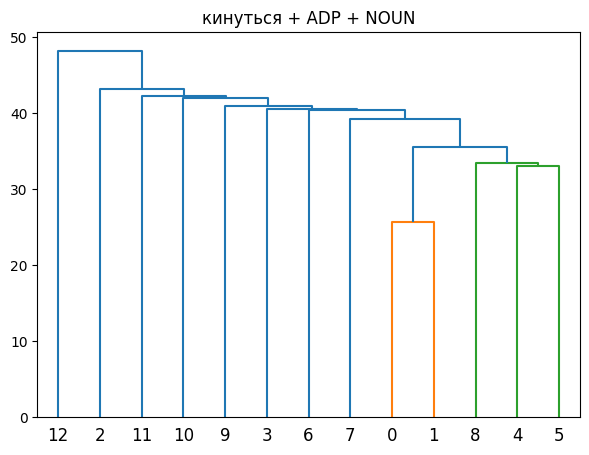

In [207]:
Z2 = hcluster.linkage(X2)
plt.figure()
dn = hcluster.dendrogram(Z2)
plt.title("кинуться + ADP + NOUN")
plt.rcParams['figure.figsize'] = [7, 5]
plt.show()

There is a file (kinutsya+s.png) in the folder in case if the plot is unreadable.

Let's compare clusters to the list of the constructions:

In [181]:
for j in range(len(df_list[1])):
    print(j, ' – ', df_list[1].iloc[j, 1])

0  –  кинуться к дверь
1  –  кинуться к окно
2  –  кинуться в вода
3  –  кинуться в сторона
4  –  кинуться на шея
5  –  кинуться в глаз
6  –  кинуться к выход
7  –  кинуться к телефон
8  –  кинуться в объятие
9  –  кинуться в дом
10  –  кинуться на помощь
11  –  кинуться на улица
12  –  кинуться в атака


There are not enough examples for this verb to see a full picture but the plot provides some information nevertheless. _кинуться в атаку_ is separated -- and I really appreciate that it is far from _кинуться в сторона_ which seems to be somewhat close pragmatically but in terms of semantics the two constructions are different. The green cluster gathers three ~metaphoric constructions -- which is debatable since _кинуться в глаза_ is relatively more metaphoric than others.

And finally let's try clusterizing all constructions:

In [179]:
array_list = []
for j in range(len(df_all)):
    v = []
    #name = ''
    abstr = nlp(df_all.iloc[j, 1])
    for token in abstr:
        if token.pos_ != 'ADP':
            n = ''
            n = n + token.text + '_' + token.pos_
            #name = name + '_' + token.text
            if n in model:
                #print(n, '\n', model[n][:5])
                vector = []
                for item in model[n]:
                    vector.append(float(item))
                v.append(np.array(vector))
            else:
                print('Слова "%s" нет в модели!' % n)
    if len(v) == 2:
        v1 = [v[0], v[1]]
        v1 = np.sum(v1, axis=0)
        array_list.append(v1)
#print(name[1:], '\n', array_list[:5])
            
X = np.array(array_list)
print(X)
print (X.shape)

[[-2.5803079   1.11180633  3.75898916 ... -0.22919584 -0.32119608
  -1.69358012]
 [ 0.71967363  3.4517166   1.37715328 ...  1.01699364  0.28019309
  -1.73047659]
 [-3.88425612  3.62893194  1.9522934  ... -3.11500251 -1.62291205
  -4.84862933]
 ...
 [ 2.73556928  6.67289492 -0.56830966 ... -0.56343269  3.16163185
   1.52795631]
 [ 4.33515386  5.72766683  3.62103105 ... -1.17985511 -1.2889007
  -1.26044625]
 [-1.30271645  4.43875691  0.26610994 ... -2.31844616 -2.69111773
  -4.44083208]]
(75, 300)


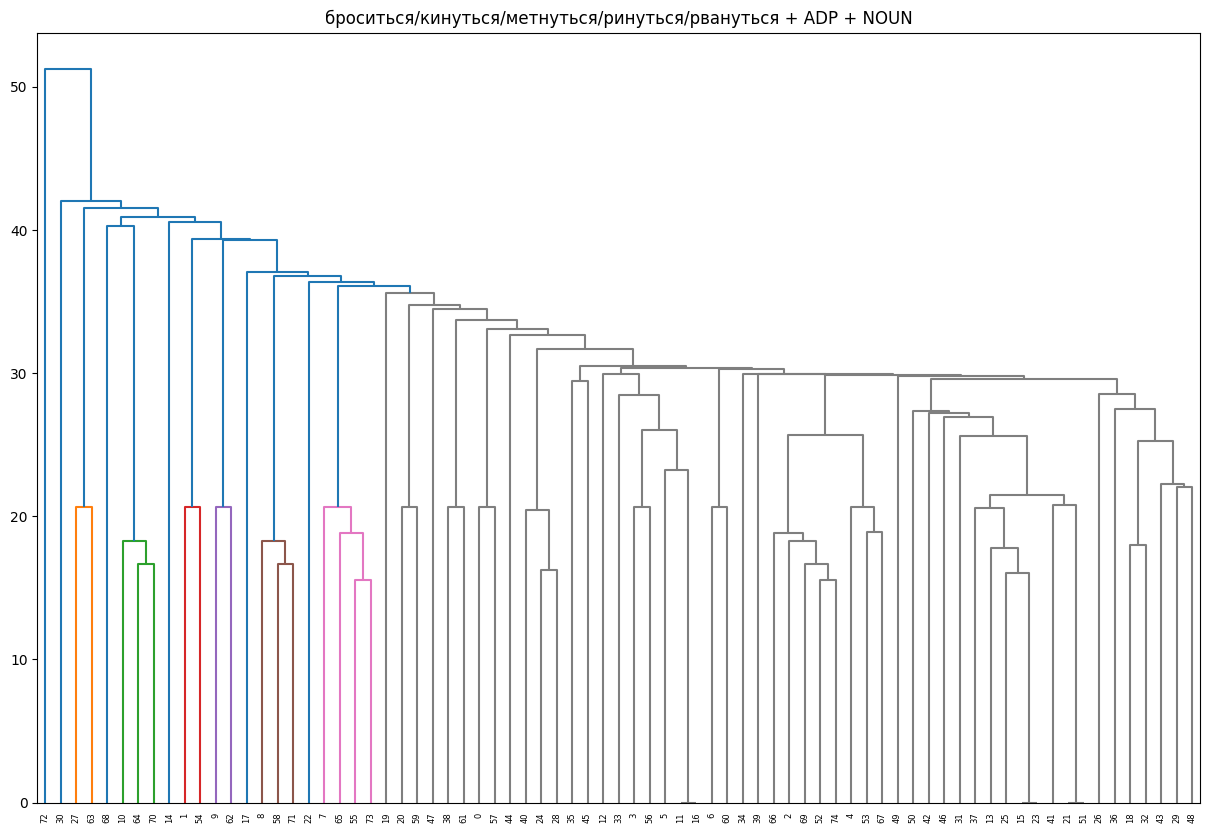

In [180]:
Z = hcluster.linkage(X)
plt.figure()
dn = hcluster.dendrogram(Z)
plt.title("броситься/кинуться/метнуться/ринуться/рвануться + ADP + NOUN")
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

There is a file (brositsya-kinutsya-metnutsya-rinutsya-rvanutsya+s.png) in the folder in case if the plot is unreadable.

Let's compare clusters to the list of the constructions:

In [29]:
for j in range(len(df_all)):
    print(j, df_all.iloc[j, 1])

0 броситься в глаз
1 броситься в вода
2 броситься к дверь
3 броситься на шея
4 броситься к окно
5 броситься на колено
6 броситься в объятие
7 броситься в сторона
8 броситься к выход
9 броситься на помощь
10 броситься в атака
11 броситься к нога
12 броситься в голова
13 броситься на диван
14 броситься в море
15 броситься на постель
16 броситься в нога
17 броситься в река
18 броситься с крик
19 броситься на земля
20 броситься к телефон
21 броситься в комната
22 броситься в лицо
23 броситься в постель
24 броситься к отец
25 броситься на кровать
26 броситься в погоня
27 броситься на улица
28 броситься к мать
29 броситься в ужас
30 броситься под поезд
31 броситься к стол
32 броситься с визг
33 броситься в рука
34 броситься со слеза
35 броситься в куст
36 броситься в паника
37 броситься в кресло
38 броситься в дом
39 броситься на пол
40 броситься к муж
41 броситься в спальня
42 броситься в коридор
43 броситься в отчаяние
44 броситься в угол
45 броситься в лес
46 броситься в кухня
47 броситьс

1. Orange cluster (27, 63): _броситься на улица_ and _кинуться на улица_
2. Green cluster (10, 64, 70): _броситься в атака_, _кинуться в атака_ and ___ринуться к дверь___
3. Red cluster (1, 54): _броситься в вода_ and _кинуться в вода_
4. Purple cluster (9, 62): _броситься на помощь_ and _кинуться на помощь_
5. Brown cluster (8, 58, 71): _броситься к выход_, _кинуться к выход_ and ___ринуться в атака___
6. Pink cluster (7, 65, 55, 73): _броситься в сторона_, _метнуться в сторона_, _кинуться в сторона_ and ___рвануться с место___

In this case clusters barely show anything unexpected: usually cluster has variations of the same construction with different verb. There are three point though:

1) _ринуться к двери_ is clusterized with _verb + в атаку_
2) _ринуться в атака_ is clusterized with _verb + к выходу_ (item 1 vice versa)
3) _рвануться с места_ is clusterized with _verb + в сторону_ -- which brings up the question whether _рвануться_ is as close to the other verbs as it seems to be. 

In [192]:
print(model.doesnt_match('броситься_VERB кинуться_VERB метнуться_VERB ринуться_VERB рвануться_VERB'.split()))

рвануться_VERB


While it is barely a surprise that _рвануться_ stands out as does _метнуться_ (in this specific study it might be due to the small representation of both verbs), it is unexpected that among _броситься_, _кинуться_ and _ринуться_ the "extra" one is _кинуться_:

In [210]:
print(model.doesnt_match('броситься_VERB кинуться_VERB ринуться_VERB'.split()))

кинуться_VERB


In [208]:
print(model.similarity('броситься_VERB', 'кинуться_VERB'))

0.7367136


In [211]:
print(model.similarity('кинуться_VERB', 'ринуться_VERB'))

0.7486977


In [191]:
print(model.similarity('броситься_VERB', 'ринуться_VERB'))

0.796581


In [209]:
print(model.similarity('броситься_VERB', 'метнуться_VERB'))

0.66585916


In [190]:
print(model.similarity('кинуться_VERB', 'рвануться_VERB'))

0.610919


As one can see this study has two major parts -- the one with a large database and the other one with clusters of a relatively small sets of constructions. The idea of the study was to apply clusterization to the database but unfortunately I was out of time by the time I figured out how clusterization works.

The other idea was to study _verb + verb_ constructions. These certain verbs appear to become auxiliaries iin some contexts and I was wondering whether or not the 'start' meaning of _броситься_ and others could be shown via python tools. This model however seems to overlook it:

In [194]:
print(model.most_similar(positive=['броситься_VERB'], negative=['бежать_VERB'])[0][0])

кидаться_VERB
